In [1]:
import nltk
#nltk.download() #check that everything is installed on the PC and uptodate

In [2]:
# pandas dataframes to hold the tweets
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = None

# use nltk for the natural language processing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pickle # to load in the saved trained model
import csv
import xlrd # it seems the csv files i saved with tweets are actually excel files
import itertools

# Machine Learning
from sklearn.model_selection import train_test_split
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# to read a directory on my PC
import glob

# to prepare the powerpoint presentation
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.enum.text import MSO_ANCHOR
from pptx.enum.dml import MSO_FILL
from pptx.dml.color import RGBColor

# # filter out all warnings 
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# check on the panda version and its dependencies
# i run this from time to time to ensure all is up to date
pd.__version__
#pd.show_versions()

'0.25.3'

In [4]:
# Presentation preperation and image saving

# toggle to switch on image saving: 0 = off, 1 = on (i.e.save images and also slide titles)
savePNG = 0

# toggle to switch on powerpoint preparation: 0 = off, 1 = on (automatically saves the images also)
PwrptPrep = 1

# list of slide titles, text and images to add
monthNow = 'April 2020'
presentationTitle = ['Twitter sentiment analysis', 'Andrew Neville', monthNow]
saveFileName = 'ASOS - twitterSentiment.pptx'
slideTitle = []
slideText = []
imagePath = []

In [5]:
# list the files in the directory, will use the list of file names to create the Dataframes

files=[]
testLength = len("C:/Users/andrew/Documents/Big Data Project/Data Collectors/Twitter/ASOS/ASOSTwitteryyyymmdd")
files = glob.glob("C:/Users/andrew/Documents/Big Data Project/Data Collectors/Twitter/ASOS/*.csv")
if len(files) == 0:
    files = []
    files = glob.glob("C:/Users/andre/Documents/Big Data Project/Data Collectors/Twitter/ASOS/*.csv")
    testLength = len("C:/Users/andre/Documents/Big Data Project/Data Collectors/Twitter/ASOS/ASOSTwitteryyyymmdd")
if len(files) == 0:
    files = []
    testLength = len("C:/Users/andre/OneDrive/Documents/Big Data Project/Data Collectors/Twitter/ASOS/asostwitteryyyymmdd")
    files = glob.glob("C:/Users/andre/OneDrive/Documents/Big Data Project/Data Collectors/Twitter/ASOS/ASOS*witter20*.*")

# # eliminate files that are names crestnicholson*.csv where the same file crestnicholson*_cleaned.csv exists
# test_to_delete = []
# for i in range(len(files)-1):
#     if files[i][0:testLength] == files[i+1][0:testLength]:
#         test_to_delete.append(files[i])

#files = sorted(list(set(files)^set(test_to_delete))) # need to keep files in order when eliminating the duplicates

#files = glob.glob("C:/Users/andrew/Documents/Big Data Project/Data Collectors/crestnicholson/crestnicholson/crestnicholson*_cleaned.csv")
print("files to read ", str(len(files)))
print("first file ",files[0])
print("last file ", files[-1])

files to read  52
first file  C:/Users/andre/OneDrive/Documents/Big Data Project/Data Collectors/Twitter/ASOS\ASOStwitter20150423.csv
last file  C:/Users/andre/OneDrive/Documents/Big Data Project/Data Collectors/Twitter/ASOS\ASOStwitter20200331.csv


In [6]:
# create DataFrames
# this will create x number of Dataframes from the csv sheets in the files list, df[0] to df[n]
# and then combine them all into one

df_files = []

for ii in range(len(files)):
    df_files.append(pd.read_excel(files[ii], header=None))

    if len(df_files[ii].columns)>1: # some excel sheets have more than one column of tweets
        df_temp=[]
        for i in range(1,len(df_files[ii].columns),2):
            df_temp.append(df_files[ii].iloc[:,i])

        a = df_temp[0]
        for i in range(1,len(df_temp)):
            a = pd.concat([a,df_temp[i]],ignore_index=True)

        df_files[ii] = a

df = df_files[0]
for i in range(1,len(df_files)):
               df = pd.concat([df,df_files[i]],ignore_index=True)
df.columns = ['tweet']              

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736615 entries, 0 to 736614
Data columns (total 1 columns):
tweet    736615 non-null object
dtypes: object(1)
memory usage: 5.6+ MB


In [8]:
# add columns of date and tweet

df['date'] = df['tweet'].str.split('[').str[1].str[:10]
df['text'] = df['tweet'].str.split(']').str[1].str[3:]

In [9]:
df.head()

,tweet,date,text
0,"1 [2015-04-02 00:59:01] - “@ASOS: Boys, get th...",2015-04-02,"“@ASOS: Boys, get the look without the hassle:..."
1,2 [2015-04-02 00:53:00] - @tort_tweets @Rickye...,2015-04-02,@tort_tweets @Rickyeatacid @ASOS HAHAHHAA
2,"3 [2015-04-02 00:40:38] - “@ASOS: Boys, get th...",2015-04-02,"“@ASOS: Boys, get the look without the hassle:..."
3,4 [2015-04-02 00:39:43] - @POPSUGARFashion @AS...,2015-04-02,@POPSUGARFashion @ASOS love it
4,5 [2015-04-02 00:33:34] - Just placed my first...,2015-04-02,Just placed my first @ASOS order! X #excited #...


In [10]:
#
# adjust the text as per the training code to map the features
#

In [11]:
# as a first step, i will need to extract features using the nltk toolset
# step 1, clean each tweet to get rid of labels, @names, urls and put into lower case
# step 2, only look at the adjectives and adverbs for the sentiment
# Step 3 filter out the stopwords and stem the rest
# step 4, uploads the common_words from the training code, they are the features
# step 5, add the features to the dataframe and populate each tweet with True or False for each feature
# Step 6, load the trained model and run it


In [12]:
# step 1

text_cleaned = []

for i in range(len(df.index)):
    tweet_to_clean = df['text'][i]
    tweet_to_clean = re.sub(r'#([^\s]+)', r'\1', tweet_to_clean) # all #hashtag goes to hashtag
    tweet_to_clean = re.sub('@[^\s]+','', tweet_to_clean) # all @name deleted
    tweet_to_clean = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet_to_clean) # all urls deleted
    tweet_to_clean = re.sub('[\s]+', ' ', tweet_to_clean) # converts all the resulting whitespace to one space only 
    tweet_to_clean = tweet_to_clean.lower() # convert all to lower case
    
    text_cleaned.append(tweet_to_clean)

df['text_cleaned'] = text_cleaned # new dataframe column with the cleaned text

In [13]:
with pd.option_context('display.max_colwidth', 140):
    print(df['text_cleaned'][0:5])

0    “ boys, get the look without the hassle: introducing the clip-in man bun! pic.twitter.com/snpd95kk1y” hahahahaha no
1                                                                                                               hahahhaa
2                                           “ boys, get the look without the hassle: introducing the clip-in man bun! " 
3                                                                                                                love it
4                                                                         just placed my first order! x excited shopping
Name: text_cleaned, dtype: object


In [14]:
# i will also need to change the column headers in case they conflict with the feature columns later
# i.e. if a feature word is 'text' or 'tweet' or 'date' etc

for i in range(3):
    df.rename(columns={df.columns[i]: df.columns[i]+'__'}, inplace=True)
    
df.head()

,tweet__,date__,text__,text_cleaned
0,"1 [2015-04-02 00:59:01] - “@ASOS: Boys, get th...",2015-04-02,"“@ASOS: Boys, get the look without the hassle:...","“ boys, get the look without the hassle: intro..."
1,2 [2015-04-02 00:53:00] - @tort_tweets @Rickye...,2015-04-02,@tort_tweets @Rickyeatacid @ASOS HAHAHHAA,hahahhaa
2,"3 [2015-04-02 00:40:38] - “@ASOS: Boys, get th...",2015-04-02,"“@ASOS: Boys, get the look without the hassle:...","“ boys, get the look without the hassle: intro..."
3,4 [2015-04-02 00:39:43] - @POPSUGARFashion @AS...,2015-04-02,@POPSUGARFashion @ASOS love it,love it
4,5 [2015-04-02 00:33:34] - Just placed my first...,2015-04-02,Just placed my first @ASOS order! X #excited #...,just placed my first order! x excited shopping


In [15]:
# step 2

adjective_flag = ["J","R","V","N"] # looking for adjectives, adverbs, verbs and nouns
tweets_adjectives = []

for i in range(len(df.index)):
    tweets_toFilter = df['text_cleaned'][i]
    words = word_tokenize(tweets_toFilter)
    word_type = nltk.pos_tag(words)

    new_tweet = []
    for w in word_type:
        if w[1][0] in adjective_flag:
            new_tweet.append(w[0].lower())
    tweets_adjectives.append(new_tweet)

df['text_adjectives'] = tweets_adjectives # new dataframe column with the filtered text

In [16]:
with pd.option_context('display.max_colwidth', 140):
    print(df['text_adjectives'][0:5])

0    [“, boys, get, look, hassle, introducing, clip-in, man, bun, pic.twitter.com/snpd95kk1y, ”, hahahahaha]
1                                                                                                 [hahahhaa]
2                                               [“, boys, get, look, hassle, introducing, clip-in, man, bun]
3                                                                                                     [love]
4                                                         [just, placed, first, order, x, excited, shopping]
Name: text_adjectives, dtype: object


In [17]:
# step 3

stop_words = stopwords.words("english")
stemmer = PorterStemmer()

In [18]:
tweets_filtStem = []

for i in range(len(df.index)):
    tweets_toFilter = df['text_adjectives'][i]
    #words = word_tokenize(tweets_toFilter) # no need to tokenize again, already done

    new_tweet = []
    for w in tweets_toFilter:
        if w not in stop_words:
            new_tweet.append(stemmer.stem(w))
    tweets_filtStem.append(new_tweet)

df['text_filtered_stemmed'] = tweets_filtStem # new dataframe column with the filtered text

In [19]:
with pd.option_context('display.max_colwidth', 140):
    print(df['text_filtered_stemmed'][0:5])

0    [“, boy, get, look, hassl, introduc, clip-in, man, bun, pic.twitter.com/snpd95kk1i, ”, hahahahaha]
1                                                                                            [hahahhaa]
2                                               [“, boy, get, look, hassl, introduc, clip-in, man, bun]
3                                                                                                [love]
4                                                                 [place, first, order, x, excit, shop]
Name: text_filtered_stemmed, dtype: object


In [20]:
# step 4

with open('common_words.csv', newline='') as f:
    reader = csv.reader(f)
    common_words = list(reader)

common_words = common_words[0]

In [21]:
common_words[0:5], len(common_words)

(["n't", 'go', "'m", "'s", 'get'], 800)

In [22]:
# Step 5
# and now for each tweet i can assign a list of x features
# which is each of the common_words marked 1 (present) or 0 (not present)

allTweet_features = []
for i in range(len(df.index)):    
    tweet_features = []
    words=set(df['text_filtered_stemmed'][i])
    for common_word in common_words:
        if common_word in words:
            tweet_features.append(1)
        else:
            tweet_features.append(0)
    allTweet_features.append(tweet_features)

In [23]:
# from these lists build them into the columns in the dataframe
# for each common word

number_of_tweets = len(df.index)
number_of_features = len(common_words)

for i in range(number_of_features):
    dataframe_feature_data = []
    for ii in range(number_of_tweets):
        dataframe_feature_data.append(allTweet_features[ii][i])
    df[common_words[i]] = dataframe_feature_data    

In [24]:
df.head()

,tweet__,date__,text__,text_cleaned,text_adjectives,text_filtered_stemmed,n't,go,'m,'s,get,day,good,work,love,quot,got,today,time,thank,want,back,miss,lol,know,u,see,feel,think,realli,im,amp,hope,night,watch,still,make,need,new,well,home,look,come,much,last,morn,twitter,tomorrow,wish,great,wait,'re,sleep,haha,sad,fun,tri,right,week,happi,follow,bad,'ve,thing,sorri,tonight,friend,say,way,take,gon,nice,better,hate,even,bed,start,tweet,peopl,school,show,hour,guy,play,weekend,final,hey,lt,let,awesom,use,dont,never,yeah,cant,soon,next,long,littl,rain,pleas,tire,first,everyon,best,movi,year,sick,life,wan,find,girl,sure,call,suck,..,done,help,head,alway,bore,talk,keep,like,alreadi,cool,lot,someth,live,eat,phone,leav,readi,hurt,read,made,man,oh,enjoy,x,went,ok,song,hous,yet,yay,ur,sound,thought,pretti,ever,mayb,na,excit,finish,away,summer,amaz,game,guess,tell,old,mean,one,listen,someon,earli,damn,lost,left,give,check,bit,babi,big,hear,parti,hot,noth,late,end,actual,glad,birthday,omg,happen,wow,also,pic,stop,sun,later,weather,wonder,@,put,mom,stuff,ta,saw,stay,fuck,hard,said,run,ya,car,exam,god,world,yesterday,kid,meet,music,that,job,beauti,updat,sunday,ye,mani,friday,post,seem,monday,n,hi,video,found,luck,cold,move,book,die,busi,gone,cri,poor,buy,boy,anyth,least,plan,shop,famili,woke,total,studi,hair,aww,food,almost,cute,iphon,lunch,believ,far,pictur,drink,free,chang,month,place,everyth,sweet,dinner,welcom,funni,tho,win,class,gt,anyon,shit,forward,turn,till,drive,sit,mine,ask,r,okay,walk,name,idea,dream,dad,caus,stupid,write,send,clean,real,coffe,enough,hahaha,ill,room,wrong,probabl,wake,didnt,dog,saturday,anymor,fan,money,minut,person,sooo,hit,ha,rememb,tv,xx,break,aw,headach,came,whole,brother,rock,seen,face,fail,repli,train,beach,hang,eye,kill,blog,=,rest,open,kinda,crazi,pain,close,mother,took,comput,care,word,quit,hell,super,worri,news,true,abl,anyway,hello,forgot,goodnight,els,problem,trip,part,bring,heart,offic,kind,photo,pay,full,link,soo,sister,mind,danc,cuz,b,boo,alon,stuck,internet,fall,test,ticket,cours,sometim,heard,pick,ugh,email,ah,site,awww,set,learn,hehe,pass,vote,interest,text,concert,wont,shower,btw,season,dude,add,awak,fine,fix,],told,ago,hand,favorit,suppos,visit,breakfast,goe,/,cat,sunni,onlin,ice,catch,serious,broke,facebook,bought,spend,ass,pack,cut,wear,lucki,crap,half,asleep,smile,reason,june,ride,lmao,hungri,agre,definit,sign,afternoon,mad,red,instead,ladi,jealou,sore,citi,stori,w/,page,figur,second,join,messag,graduat,album,top,nap,homework,soooo,xd,la,list,congrat,date,togeth,tour,bye,coupl,laptop,dead,park,holiday,wed,sing,save,high,til,water,goin,store,award,+,revis,yea,drop,point,star,moment,complet,relax,dear,perfect,dress,download,church,ppl,short,account,share,side,cook,ipod,line,offici,hug,answer,tea,decid,realiz,youtub,ive,town,annoy,nite,forget,lose,order,scare,weird,gym,mood,unfortun,lil,cream,min,outsid,math,understand,air,english,mum,differ,fb,fli,usual,ate,less,chocol,pool,knew,episod,band,comment,worst,[,upload,fast,support,window,chanc,horribl,flight,load,kick,parent,around,london,question,broken,da,throat,cheer,laugh,team,black,chat,card,sunshin,special,xxx,%,sat,sent,upset,gave,followfriday,sleepi,number,slow,depress,beat,ahh,ad,green,colleg,yep,mac,leg,bless,record,fell,moon,project,appar,paper,what,jona,cake,tuesday,garden,beer,wors,rather,vacat,power,film,websit,doesnt,possibl,longer,warm,app,easi,bet,bodi,bday,blue,due,fair,p,mess,huge,light,c,spent,freak,shoe,finger,hmm,celebr,disappoint,safe,past,lay,juli,cancel,sim,chill,miley,mtv,shame,cousin,bu,earlier,flu,googl,burn,lazi,absolut,age,voic,thx,stomach,white,remind,nope,hold,forev,swim,bike,thursday,manag,stress,wtf,touch,camp,especi,met,shot,camera,appreci,babe,slept,current,sort,son,crash,bum,boyfriend,lie,uk,pray,david,appl,sadli,cd,idk,box,shoot,dm,fight,piss,havent,tom,ahhh,airport,co,type,cover,myspac,block,case,terribl,arriv,present,servic,meant,si,invit,note,expect,bbq,road,pizza,club,bitch,hospit,father,chicken,raini,small,

In [25]:
# step 5 load the pickled classifier trained in the training code

print('using the pickled version')
stack_f = open('stack_saved','rb')
stack = pickle.load(stack_f)
stack_f.close()

using the pickled version


In [26]:
# define X

feature_cols = [col for col in list(df.columns)[6:]]
# i.e. all the feature columns only

X = df[feature_cols]

X.shape

(736615, 800)

In [27]:
X.head()

,n't,go,'m,'s,get,day,good,work,love,quot,got,today,time,thank,want,back,miss,lol,know,u,see,feel,think,realli,im,amp,hope,night,watch,still,make,need,new,well,home,look,come,much,last,morn,twitter,tomorrow,wish,great,wait,'re,sleep,haha,sad,fun,tri,right,week,happi,follow,bad,'ve,thing,sorri,tonight,friend,say,way,take,gon,nice,better,hate,even,bed,start,tweet,peopl,school,show,hour,guy,play,weekend,final,hey,lt,let,awesom,use,dont,never,yeah,cant,soon,next,long,littl,rain,pleas,tire,first,everyon,best,movi,year,sick,life,wan,find,girl,sure,call,suck,..,done,help,head,alway,bore,talk,keep,like,alreadi,cool,lot,someth,live,eat,phone,leav,readi,hurt,read,made,man,oh,enjoy,x,went,ok,song,hous,yet,yay,ur,sound,thought,pretti,ever,mayb,na,excit,finish,away,summer,amaz,game,guess,tell,old,mean,one,listen,someon,earli,damn,lost,left,give,check,bit,babi,big,hear,parti,hot,noth,late,end,actual,glad,birthday,omg,happen,wow,also,pic,stop,sun,later,weather,wonder,@,put,mom,stuff,ta,saw,stay,fuck,hard,said,run,ya,car,exam,god,world,yesterday,kid,meet,music,that,job,beauti,updat,sunday,ye,mani,friday,post,seem,monday,n,hi,video,found,luck,cold,move,book,die,busi,gone,cri,poor,buy,boy,anyth,least,plan,shop,famili,woke,total,studi,hair,aww,food,almost,cute,iphon,lunch,believ,far,pictur,drink,free,chang,month,place,everyth,sweet,dinner,welcom,funni,tho,win,class,gt,anyon,shit,forward,turn,till,drive,sit,mine,ask,r,okay,walk,name,idea,dream,dad,caus,stupid,write,send,clean,real,coffe,enough,hahaha,ill,room,wrong,probabl,wake,didnt,dog,saturday,anymor,fan,money,minut,person,sooo,hit,ha,rememb,tv,xx,break,aw,headach,came,whole,brother,rock,seen,face,fail,repli,train,beach,hang,eye,kill,blog,=,rest,open,kinda,crazi,pain,close,mother,took,comput,care,word,quit,hell,super,worri,news,true,abl,anyway,hello,forgot,goodnight,els,problem,trip,part,bring,heart,offic,kind,photo,pay,full,link,soo,sister,mind,danc,cuz,b,boo,alon,stuck,internet,fall,test,ticket,cours,sometim,heard,pick,ugh,email,ah,site,awww,set,learn,hehe,pass,vote,interest,text,concert,wont,shower,btw,season,dude,add,awak,fine,fix,],told,ago,hand,favorit,suppos,visit,breakfast,goe,/,cat,sunni,onlin,ice,catch,serious,broke,facebook,bought,spend,ass,pack,cut,wear,lucki,crap,half,asleep,smile,reason,june,ride,lmao,hungri,agre,definit,sign,afternoon,mad,red,instead,ladi,jealou,sore,citi,stori,w/,page,figur,second,join,messag,graduat,album,top,nap,homework,soooo,xd,la,list,congrat,date,togeth,tour,bye,coupl,laptop,dead,park,holiday,wed,sing,save,high,til,water,goin,store,award,+,revis,yea,drop,point,star,moment,complet,relax,dear,perfect,dress,download,church,ppl,short,account,share,side,cook,ipod,line,offici,hug,answer,tea,decid,realiz,youtub,ive,town,annoy,nite,forget,lose,order,scare,weird,gym,mood,unfortun,lil,cream,min,outsid,math,understand,air,english,mum,differ,fb,fli,usual,ate,less,chocol,pool,knew,episod,band,comment,worst,[,upload,fast,support,window,chanc,horribl,flight,load,kick,parent,around,london,question,broken,da,throat,cheer,laugh,team,black,chat,card,sunshin,special,xxx,%,sat,sent,upset,gave,followfriday,sleepi,number,slow,depress,beat,ahh,ad,green,colleg,yep,mac,leg,bless,record,fell,moon,project,appar,paper,what,jona,cake,tuesday,garden,beer,wors,rather,vacat,power,film,websit,doesnt,possibl,longer,warm,app,easi,bet,bodi,bday,blue,due,fair,p,mess,huge,light,c,spent,freak,shoe,finger,hmm,celebr,disappoint,safe,past,lay,juli,cancel,sim,chill,miley,mtv,shame,cousin,bu,earlier,flu,googl,burn,lazi,absolut,age,voic,thx,stomach,white,remind,nope,hold,forev,swim,bike,thursday,manag,stress,wtf,touch,camp,especi,met,shot,camera,appreci,babe,slept,current,sort,son,crash,bum,boyfriend,lie,uk,pray,david,appl,sadli,cd,idk,box,shoot,dm,fight,piss,havent,tom,ahhh,airport,co,type,cover,myspac,block,case,terribl,arriv,present,servic,meant,si,invit,note,expect,bbq,road,pizza,club,bitch,hospit,father,chicken,raini,small,deal,yummi,interview,confus,shirt,tummi,bro,luv,count,fit,tast,cloth,doct

In [28]:
prediction = stack.predict(X)

In [29]:
df['sentiment'] = prediction

In [30]:
df['sentiment'].unique()

array([4, 0], dtype=int64)

In [31]:
df['sentiment'].value_counts()

4    524396
0    212219
Name: sentiment, dtype: int64

In [32]:
# change 'date' column to date format
df['date__'] = pd.to_datetime(df['date__'], dayfirst=True)

In [33]:
df.head()

,tweet__,date__,text__,text_cleaned,text_adjectives,text_filtered_stemmed,n't,go,'m,'s,get,day,good,work,love,quot,got,today,time,thank,want,back,miss,lol,know,u,see,feel,think,realli,im,amp,hope,night,watch,still,make,need,new,well,home,look,come,much,last,morn,twitter,tomorrow,wish,great,wait,'re,sleep,haha,sad,fun,tri,right,week,happi,follow,bad,'ve,thing,sorri,tonight,friend,say,way,take,gon,nice,better,hate,even,bed,start,tweet,peopl,school,show,hour,guy,play,weekend,final,hey,lt,let,awesom,use,dont,never,yeah,cant,soon,next,long,littl,rain,pleas,tire,first,everyon,best,movi,year,sick,life,wan,find,girl,sure,call,suck,..,done,help,head,alway,bore,talk,keep,like,alreadi,cool,lot,someth,live,eat,phone,leav,readi,hurt,read,made,man,oh,enjoy,x,went,ok,song,hous,yet,yay,ur,sound,thought,pretti,ever,mayb,na,excit,finish,away,summer,amaz,game,guess,tell,old,mean,one,listen,someon,earli,damn,lost,left,give,check,bit,babi,big,hear,parti,hot,noth,late,end,actual,glad,birthday,omg,happen,wow,also,pic,stop,sun,later,weather,wonder,@,put,mom,stuff,ta,saw,stay,fuck,hard,said,run,ya,car,exam,god,world,yesterday,kid,meet,music,that,job,beauti,updat,sunday,ye,mani,friday,post,seem,monday,n,hi,video,found,luck,cold,move,book,die,busi,gone,cri,poor,buy,boy,anyth,least,plan,shop,famili,woke,total,studi,hair,aww,food,almost,cute,iphon,lunch,believ,far,pictur,drink,free,chang,month,place,everyth,sweet,dinner,welcom,funni,tho,win,class,gt,anyon,shit,forward,turn,till,drive,sit,mine,ask,r,okay,walk,name,idea,dream,dad,caus,stupid,write,send,clean,real,coffe,enough,hahaha,ill,room,wrong,probabl,wake,didnt,dog,saturday,anymor,fan,money,minut,person,sooo,hit,ha,rememb,tv,xx,break,aw,headach,came,whole,brother,rock,seen,face,fail,repli,train,beach,hang,eye,kill,blog,=,rest,open,kinda,crazi,pain,close,mother,took,comput,care,word,quit,hell,super,worri,news,true,abl,anyway,hello,forgot,goodnight,els,problem,trip,part,bring,heart,offic,kind,photo,pay,full,link,soo,sister,mind,danc,cuz,b,boo,alon,stuck,internet,fall,test,ticket,cours,sometim,heard,pick,ugh,email,ah,site,awww,set,learn,hehe,pass,vote,interest,text,concert,wont,shower,btw,season,dude,add,awak,fine,fix,],told,ago,hand,favorit,suppos,visit,breakfast,goe,/,cat,sunni,onlin,ice,catch,serious,broke,facebook,bought,spend,ass,pack,cut,wear,lucki,crap,half,asleep,smile,reason,june,ride,lmao,hungri,agre,definit,sign,afternoon,mad,red,instead,ladi,jealou,sore,citi,stori,w/,page,figur,second,join,messag,graduat,album,top,nap,homework,soooo,xd,la,list,congrat,date,togeth,tour,bye,coupl,laptop,dead,park,holiday,wed,sing,save,high,til,water,goin,store,award,+,revis,yea,drop,point,star,moment,complet,relax,dear,perfect,dress,download,church,ppl,short,account,share,side,cook,ipod,line,offici,hug,answer,tea,decid,realiz,youtub,ive,town,annoy,nite,forget,lose,order,scare,weird,gym,mood,unfortun,lil,cream,min,outsid,math,understand,air,english,mum,differ,fb,fli,usual,ate,less,chocol,pool,knew,episod,band,comment,worst,[,upload,fast,support,window,chanc,horribl,flight,load,kick,parent,around,london,question,broken,da,throat,cheer,laugh,team,black,chat,card,sunshin,special,xxx,%,sat,sent,upset,gave,followfriday,sleepi,number,slow,depress,beat,ahh,ad,green,colleg,yep,mac,leg,bless,record,fell,moon,project,appar,paper,what,jona,cake,tuesday,garden,beer,wors,rather,vacat,power,film,websit,doesnt,possibl,longer,warm,app,easi,bet,bodi,bday,blue,due,fair,p,mess,huge,light,c,spent,freak,shoe,finger,hmm,celebr,disappoint,safe,past,lay,juli,cancel,sim,chill,miley,mtv,shame,cousin,bu,earlier,flu,googl,burn,lazi,absolut,age,voic,thx,stomach,white,remind,nope,hold,forev,swim,bike,thursday,manag,stress,wtf,touch,camp,especi,met,shot,camera,appreci,babe,slept,current,sort,son,crash,bum,boyfriend,lie,uk,pray,david,appl,sadli,cd,idk,box,shoot,dm,fight,piss,havent,tom,ahhh,airport,co,type,cover,myspac,block,case,terribl,arriv,present,servic,meant,si,invit,note,expect,bbq,road,pizza,club,bitch,hospit,father,chicken,raini,small,

In [34]:
# create a new data frame that counts the number of 0 sentiment scores for each date

df_daily_negative = df['sentiment'].eq(0).groupby(df['date__']).sum().astype(int).reset_index()


In [35]:
df_daily_negative['sentiment_pos'] = list(df['sentiment'].eq(4).groupby(df['date__']).sum().astype(int))
df_daily_negative['total_tweets'] = list(df['sentiment'].groupby(df['date__']).count().astype(int))
df_daily_negative['check_col'] = df_daily_negative['total_tweets'] - df_daily_negative['sentiment'] - \
df_daily_negative['sentiment_pos']
df_daily_negative['%_neg_tweets'] = df_daily_negative['sentiment']/df_daily_negative['total_tweets']

In [36]:
df_daily_negative['check_col'].sum()

0

In [37]:
df_daily_negative.head()

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets
0,2015-04-01,699,2076,2775,0,0.251892
1,2015-04-02,440,609,1049,0,0.419447
2,2015-04-03,125,394,519,0,0.240848
3,2015-04-04,130,280,410,0,0.317073
4,2015-04-05,78,293,371,0,0.210243


In [38]:
# set first day and last day for presentation titles

first_day_tweet = str(df['date__'][0].strftime('%Y-%m-%d'))
last_day_tweet = str(df['date__'][len(df['date__'])-1].strftime('%Y-%m-%d'))

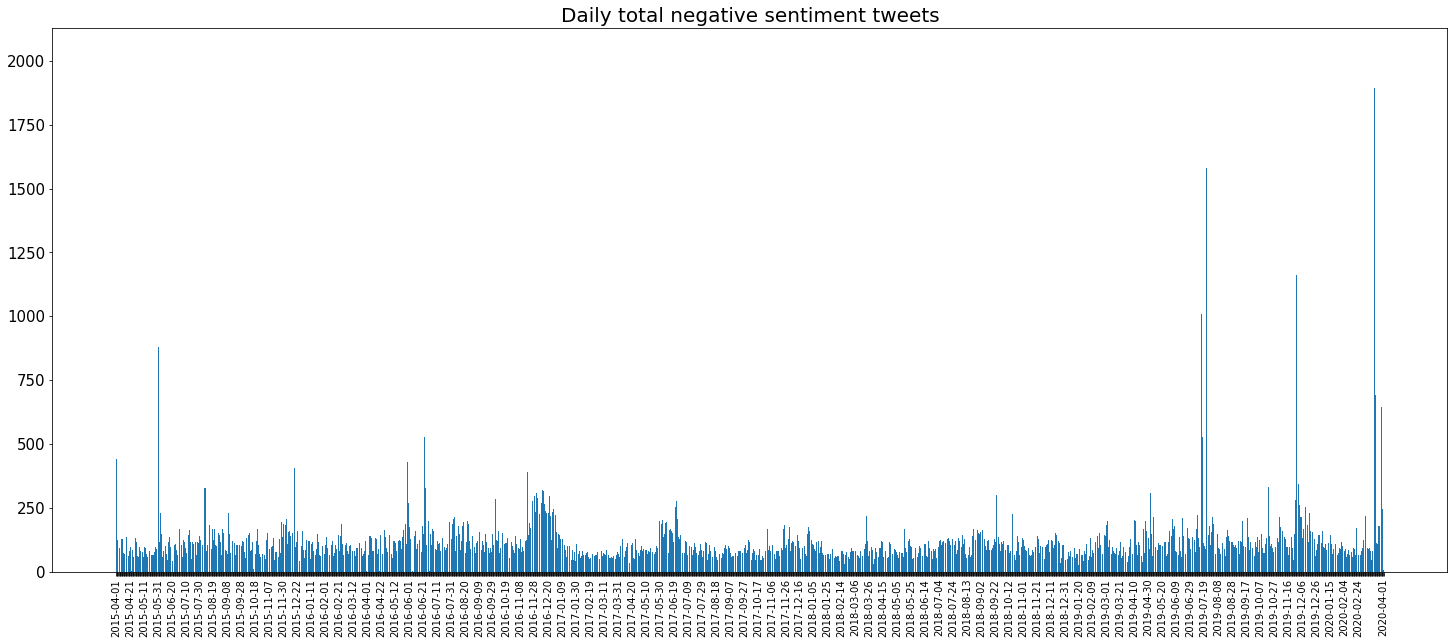

In [39]:
# plt chart of daily negative tweets

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))

plt.subplots_adjust(hspace=0.4, wspace=0.1)
#plt.suptitle('Charts showing Total Cars and then split by New, Nearly New and Used\n(watch the y-axis!!)', fontsize = 20)

x = df_daily_negative['date__'].astype(str)

labels = list(df_daily_negative['date__'].astype(str))

label_space = 20
for i in range(label_space,len(labels),label_space):
    for ii in range(1,label_space):
        labels[i-ii]=''

labels[len(labels)-1]=list(df_daily_negative['date__'].astype(str))[-1]
for ii in range(2,label_space):
    labels[len(labels)-ii]=''

y1 = df_daily_negative['sentiment']
ax.set_title('Daily total negative sentiment tweets', fontsize=20)
ax.set_xticklabels(labels, rotation = 90)
ax.yaxis.set_tick_params(labelsize=15)
ax.bar(x, y1)


if savePNG == 1 or PwrptPrep == 1:
    plt.savefig('Twitter - justeat - daily negative tweets.png', bbox_inches = 'tight')
    
    slideTitle.append('Daily negative Tweets')
    slideText.append(first_day_tweet + ' to ' + last_day_tweet)
    imagePath.append('Twitter - justeat - daily negative tweets.png')
        
plt.show()


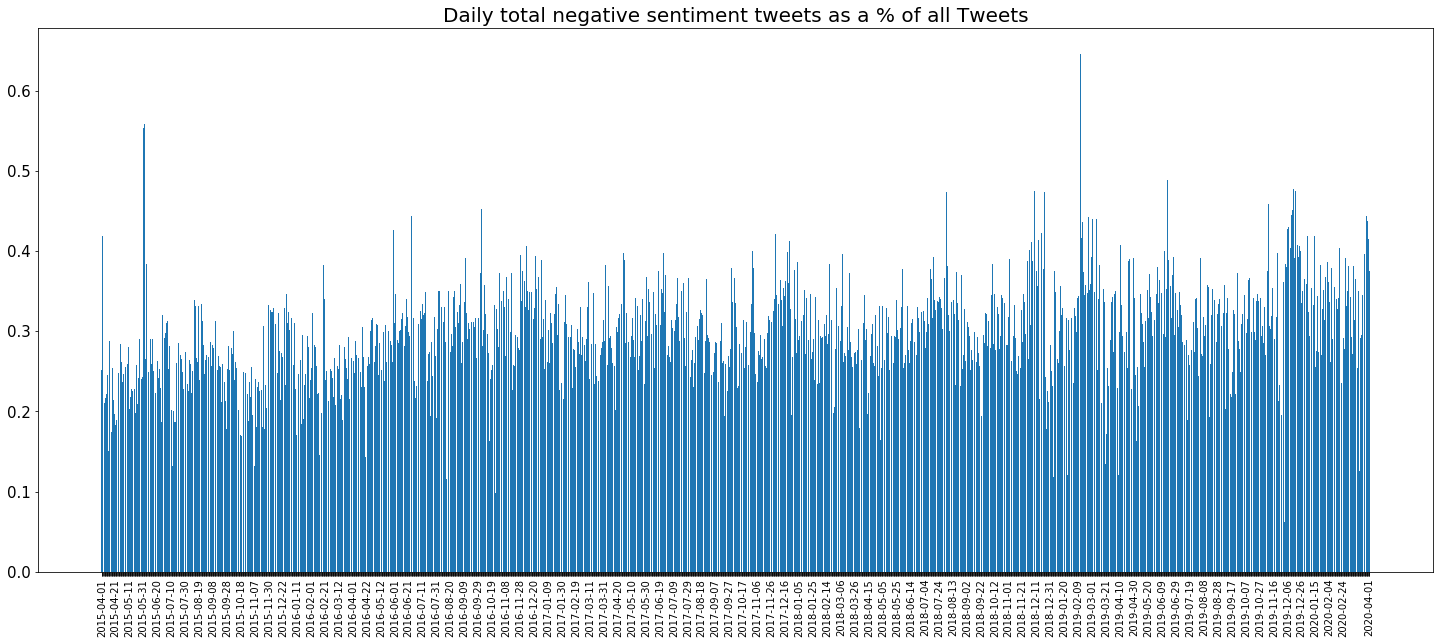

In [40]:
# plt chart of daily % negative tweets

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))

plt.subplots_adjust(hspace=0.4, wspace=0.1)
#plt.suptitle('Charts showing Total Cars and then split by New, Nearly New and Used\n(watch the y-axis!!)', fontsize = 20)

x = df_daily_negative['date__'].astype(str)

labels = list(df_daily_negative['date__'].astype(str))

label_space = 20
for i in range(label_space,len(labels),label_space):
    for ii in range(1,label_space):
        labels[i-ii]=''

labels[len(labels)-1]=list(df_daily_negative['date__'].astype(str))[-1]
for ii in range(2,label_space):
    labels[len(labels)-ii]=''

y1 = df_daily_negative['%_neg_tweets']
ax.set_title('Daily total negative sentiment tweets as a % of all Tweets', fontsize=20)
ax.set_xticklabels(labels, rotation = 90)
ax.yaxis.set_tick_params(labelsize=15)
ax.bar(x, y1)


if savePNG == 1 or PwrptPrep == 1:
    plt.savefig('Twitter - justeat - daily pct negative tweets.png', bbox_inches = 'tight')
    
    slideTitle.append('Daily negative Tweets as a % of all Tweets')
    slideText.append(first_day_tweet + ' to ' + last_day_tweet)
    imagePath.append('Twitter - justeat - daily pct negative tweets.png')
        
plt.show()


In [41]:
# calculate outliers using a 180 day rolling average
# to cater for changes in volumes of tweets over time

days = 180 # rolling average days
std_number = 4 # number of std deviations to be considered an outlier

df_daily_negative['rolling average'] = df_daily_negative['sentiment'].rolling(days).mean()
df_daily_negative['rolling std dev'] = df_daily_negative['sentiment'].rolling(days).std()
df_daily_negative['outlier'] = df_daily_negative['rolling average'] + std_number*df_daily_negative['rolling std dev']

In [42]:
# calculate outliers for % tweets using a 180 day rolling average
# assume no change over time

std_number_pct = 4 # number of std deviations to be considered an outlier

df_daily_negative['% average'] = df_daily_negative['%_neg_tweets'].mean()
df_daily_negative['% std dev'] = df_daily_negative['%_neg_tweets'].std()
df_daily_negative['% outlier'] = df_daily_negative['% average'] + std_number_pct*df_daily_negative['% std dev']

In [43]:
df_daily_negative.tail()

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets,rolling average,rolling std dev,outlier,% average,% std dev,% outlier
1813,2020-03-28,421,527,948,0,0.444093,159.166667,195.636634,941.713204,0.297321,0.06113,0.541842
1814,2020-03-29,645,827,1472,0,0.438179,162.122222,198.926186,957.826966,0.297321,0.06113,0.541842
1815,2020-03-30,247,440,687,0,0.359534,162.961111,198.964171,958.817797,0.297321,0.06113,0.541842
1816,2020-03-31,240,338,578,0,0.415225,163.538889,199.036432,959.684617,0.297321,0.06113,0.541842
1817,2020-04-01,6,10,16,0,0.375000,162.905556,199.356863,960.333006,0.297321,0.06113,0.541842


In [44]:
# create lists of tweets for the days that are outliers

outlier_days = list(df_daily_negative[df_daily_negative['sentiment'] > df_daily_negative['outlier']]['date__'])
outlier_days_pct = list(df_daily_negative[df_daily_negative['%_neg_tweets'] > df_daily_negative['% outlier']]['date__'])

outlier_tweets = []
outlier_tweets_pct = []
                                          

for date in outlier_days:
    outlier_tweets.append(list(df[df['date__'] == date]['tweet__']))
                                          
for date in outlier_days_pct:
    outlier_tweets_pct.append(list(df[df['date__'] == date]['tweet__']))

In [45]:
outlier_tweets[0][0:10]

['4662 [2015-12-18 23:58:41] - @Quinoderm Fingers crossed for a #WhiteChristmas where these @ASOS #festive #socks are a necessity! RT and Follow to #win',
 '4663 [2015-12-18 23:58:31] - RT @Quinoderm Fingers crossed for a #WhiteChristmas where these @ASOS #festive #socks are a necessity! RT and Follow to #win',
 '4664 [2015-12-18 23:50:51] - @ASOS  #ChristmasMadeMeDoIt',
 '4665 [2015-12-18 23:47:17] - 3rd time wearing these are you messing @ASOS pic.twitter.com/tEhDsaOrxC',
 '4666 [2015-12-18 23:46:18] - @ASOS ',
 '4667 [2015-12-18 23:44:32] - @ASOS  #ChristmasMadeMeDoIt',
 '4668 [2015-12-18 23:40:47] - @ASOS #ChristmasMadeMeDoIt ',
 "4669 [2015-12-18 23:33:20] - @ASOS yay! Can't wait to see what it is hehe  Thanks @ASOS  x x",
 '4670 [2015-12-18 23:32:17] - Who is this? I wish you would credit your models! I joined twitter just to ask :3 http://www.asos.com/ASOS/ASOS-Roll-Neck-Jumper-in-Twisted-Yarn/Prod/pgeproduct.aspx?iid=5225062\xa0… via @asos',
 '4671 [2015-12-18 23:31:25] - @ASOS

In [46]:
outlier_tweets_pct[0][0:10]

['12100 [2015-05-31 00:48:21] - @ASOS now???',
 "12101 [2015-05-31 00:47:38] - I'm so annoyed!!! I placed an order to @ASOS @ASOS_HeretoHelp 4 hours ago and then they announce a massive sale tomorrow #mylife ",
 '12102 [2015-05-31 00:33:18] - @AshmanAndrew @ASOS thanks! Alarm set for 07:55 ',
 '12103 [2015-05-31 00:32:03] - @ASOS dress\n@bysi_intl jacket\n@Matalan heels\n@GlassesShop shadespic.twitter.com/rfcaeFTysD',
 '12104 [2015-05-31 00:29:06] - @AshmanAndrew @ASOS cheers',
 "12105 [2015-05-31 00:27:08] - @AshmanAndrew @ASOS oh maaan it's well gonna have sold out then, thank you!!",
 '12106 [2015-05-31 00:24:20] - @ASOS when are you getting more stock of your black high waisted leggings? (£8) i need more in my life!',
 '12107 [2015-05-31 00:23:30] - Love this @ASOS suit - very Dolce & Gabbana inspired: http://fave.co/1ABDHq7\xa0 #fashion #shopping #summerpic.twitter.com/UU9Iz1Njz0',
 '12108 [2015-05-31 00:22:58] - @Giorgia_17 @ASOS is there a code or anything?',
 '12109 [2015-05-31

In [47]:
# write these lists to an excel file, one list per sheet

writer = pd.ExcelWriter('negative_tweet_sheets.xlsx', engine='xlsxwriter')
for i in range(len(outlier_days)):
    df_excel = pd.DataFrame(np.array(outlier_tweets[i]), columns = ['tweets__'])
    df_excel.to_excel(writer, sheet_name=(outlier_days[i].strftime('%Y-%m-%d')), index=False, columns=None)
writer.save()

In [48]:
len(outlier_tweets), len(outlier_tweets_pct)

(16, 5)

In [49]:
df.tail()

,tweet__,date__,text__,text_cleaned,text_adjectives,text_filtered_stemmed,n't,go,'m,'s,get,day,good,work,love,quot,got,today,time,thank,want,back,miss,lol,know,u,see,feel,think,realli,im,amp,hope,night,watch,still,make,need,new,well,home,look,come,much,last,morn,twitter,tomorrow,wish,great,wait,'re,sleep,haha,sad,fun,tri,right,week,happi,follow,bad,'ve,thing,sorri,tonight,friend,say,way,take,gon,nice,better,hate,even,bed,start,tweet,peopl,school,show,hour,guy,play,weekend,final,hey,lt,let,awesom,use,dont,never,yeah,cant,soon,next,long,littl,rain,pleas,tire,first,everyon,best,movi,year,sick,life,wan,find,girl,sure,call,suck,..,done,help,head,alway,bore,talk,keep,like,alreadi,cool,lot,someth,live,eat,phone,leav,readi,hurt,read,made,man,oh,enjoy,x,went,ok,song,hous,yet,yay,ur,sound,thought,pretti,ever,mayb,na,excit,finish,away,summer,amaz,game,guess,tell,old,mean,one,listen,someon,earli,damn,lost,left,give,check,bit,babi,big,hear,parti,hot,noth,late,end,actual,glad,birthday,omg,happen,wow,also,pic,stop,sun,later,weather,wonder,@,put,mom,stuff,ta,saw,stay,fuck,hard,said,run,ya,car,exam,god,world,yesterday,kid,meet,music,that,job,beauti,updat,sunday,ye,mani,friday,post,seem,monday,n,hi,video,found,luck,cold,move,book,die,busi,gone,cri,poor,buy,boy,anyth,least,plan,shop,famili,woke,total,studi,hair,aww,food,almost,cute,iphon,lunch,believ,far,pictur,drink,free,chang,month,place,everyth,sweet,dinner,welcom,funni,tho,win,class,gt,anyon,shit,forward,turn,till,drive,sit,mine,ask,r,okay,walk,name,idea,dream,dad,caus,stupid,write,send,clean,real,coffe,enough,hahaha,ill,room,wrong,probabl,wake,didnt,dog,saturday,anymor,fan,money,minut,person,sooo,hit,ha,rememb,tv,xx,break,aw,headach,came,whole,brother,rock,seen,face,fail,repli,train,beach,hang,eye,kill,blog,=,rest,open,kinda,crazi,pain,close,mother,took,comput,care,word,quit,hell,super,worri,news,true,abl,anyway,hello,forgot,goodnight,els,problem,trip,part,bring,heart,offic,kind,photo,pay,full,link,soo,sister,mind,danc,cuz,b,boo,alon,stuck,internet,fall,test,ticket,cours,sometim,heard,pick,ugh,email,ah,site,awww,set,learn,hehe,pass,vote,interest,text,concert,wont,shower,btw,season,dude,add,awak,fine,fix,],told,ago,hand,favorit,suppos,visit,breakfast,goe,/,cat,sunni,onlin,ice,catch,serious,broke,facebook,bought,spend,ass,pack,cut,wear,lucki,crap,half,asleep,smile,reason,june,ride,lmao,hungri,agre,definit,sign,afternoon,mad,red,instead,ladi,jealou,sore,citi,stori,w/,page,figur,second,join,messag,graduat,album,top,nap,homework,soooo,xd,la,list,congrat,date,togeth,tour,bye,coupl,laptop,dead,park,holiday,wed,sing,save,high,til,water,goin,store,award,+,revis,yea,drop,point,star,moment,complet,relax,dear,perfect,dress,download,church,ppl,short,account,share,side,cook,ipod,line,offici,hug,answer,tea,decid,realiz,youtub,ive,town,annoy,nite,forget,lose,order,scare,weird,gym,mood,unfortun,lil,cream,min,outsid,math,understand,air,english,mum,differ,fb,fli,usual,ate,less,chocol,pool,knew,episod,band,comment,worst,[,upload,fast,support,window,chanc,horribl,flight,load,kick,parent,around,london,question,broken,da,throat,cheer,laugh,team,black,chat,card,sunshin,special,xxx,%,sat,sent,upset,gave,followfriday,sleepi,number,slow,depress,beat,ahh,ad,green,colleg,yep,mac,leg,bless,record,fell,moon,project,appar,paper,what,jona,cake,tuesday,garden,beer,wors,rather,vacat,power,film,websit,doesnt,possibl,longer,warm,app,easi,bet,bodi,bday,blue,due,fair,p,mess,huge,light,c,spent,freak,shoe,finger,hmm,celebr,disappoint,safe,past,lay,juli,cancel,sim,chill,miley,mtv,shame,cousin,bu,earlier,flu,googl,burn,lazi,absolut,age,voic,thx,stomach,white,remind,nope,hold,forev,swim,bike,thursday,manag,stress,wtf,touch,camp,especi,met,shot,camera,appreci,babe,slept,current,sort,son,crash,bum,boyfriend,lie,uk,pray,david,appl,sadli,cd,idk,box,shoot,dm,fight,piss,havent,tom,ahhh,airport,co,type,cover,myspac,block,case,terribl,arriv,present,servic,meant,si,invit,note,expect,bbq,road,pizza,club,bitch,hospit,father,chicken,raini,small,

In [50]:
df_daily_negative.head()

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets,rolling average,rolling std dev,outlier,% average,% std dev,% outlier
0,2015-04-01,699,2076,2775,0,0.251892,NaN,NaN,NaN,0.297321,0.06113,0.541842
1,2015-04-02,440,609,1049,0,0.419447,NaN,NaN,NaN,0.297321,0.06113,0.541842
2,2015-04-03,125,394,519,0,0.240848,NaN,NaN,NaN,0.297321,0.06113,0.541842
3,2015-04-04,130,280,410,0,0.317073,NaN,NaN,NaN,0.297321,0.06113,0.541842
4,2015-04-05,78,293,371,0,0.210243,NaN,NaN,NaN,0.297321,0.06113,0.541842


In [51]:
df_daily_negative.nlargest(20, columns=['sentiment'])

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets,rolling average,rolling std dev,outlier,% average,% std dev,% outlier
443,2016-06-24,2027,1730,3757,0,0.539526,119.472222,153.149703,732.071035,0.297321,0.06113,0.541842
1804,2020-03-19,1895,4610,6505,0,0.291314,152.061111,190.783101,915.193517,0.297321,0.06113,0.541842
1563,2019-07-22,1582,4080,5662,0,0.279407,125.138889,141.273884,690.234424,0.297321,0.06113,0.541842
60,2015-05-31,1465,1181,2646,0,0.553666,NaN,NaN,NaN,0.297321,0.06113,0.541842
1692,2019-11-28,1160,14521,15681,0,0.073975,146.850000,160.776450,789.955799,0.297321,0.06113,0.541842
1733,2020-01-08,1075,677,1752,0,0.613584,164.700000,181.772923,891.791692,0.297321,0.06113,0.541842
1556,2019-07-15,1008,4304,5312,0,0.189759,113.266667,84.630092,451.787036,0.297321,0.06113,0.541842
61,2015-06-01,881,694,1575,0,0.559365,NaN,NaN,NaN,0.297321,0.06113,0.541842
1693,2019-11-29,783,2338,3121,0,0.250881,150.427778,167.620615,820.910240,0.297321,0.06113,0.541842
1803,2020-03-18,722,5038,5760,0,0.125347,142.144444,139.061263,698.389497,0.297321,0.06113,0.541842


In [52]:
df_daily_negative.nlargest(20, columns=['sentiment'])

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets,rolling average,rolling std dev,outlier,% average,% std dev,% outlier
443,2016-06-24,2027,1730,3757,0,0.539526,119.472222,153.149703,732.071035,0.297321,0.06113,0.541842
1804,2020-03-19,1895,4610,6505,0,0.291314,152.061111,190.783101,915.193517,0.297321,0.06113,0.541842
1563,2019-07-22,1582,4080,5662,0,0.279407,125.138889,141.273884,690.234424,0.297321,0.06113,0.541842
60,2015-05-31,1465,1181,2646,0,0.553666,NaN,NaN,NaN,0.297321,0.06113,0.541842
1692,2019-11-28,1160,14521,15681,0,0.073975,146.850000,160.776450,789.955799,0.297321,0.06113,0.541842
1733,2020-01-08,1075,677,1752,0,0.613584,164.700000,181.772923,891.791692,0.297321,0.06113,0.541842
1556,2019-07-15,1008,4304,5312,0,0.189759,113.266667,84.630092,451.787036,0.297321,0.06113,0.541842
61,2015-06-01,881,694,1575,0,0.559365,NaN,NaN,NaN,0.297321,0.06113,0.541842
1693,2019-11-29,783,2338,3121,0,0.250881,150.427778,167.620615,820.910240,0.297321,0.06113,0.541842
1803,2020-03-18,722,5038,5760,0,0.125347,142.144444,139.061263,698.389497,0.297321,0.06113,0.541842


In [53]:
df_daily_negative.nlargest(20, columns=['%_neg_tweets'])

,date__,sentiment,sentiment_pos,total_tweets,check_col,%_neg_tweets,rolling average,rolling std dev,outlier,% average,% std dev,% outlier
1403,2019-02-12,221,121,342,0,0.646199,102.788889,55.918435,326.462629,0.297321,0.06113,0.541842
1422,2019-03-03,189,115,304,0,0.621711,101.216667,55.624768,323.715738,0.297321,0.06113,0.541842
1733,2020-01-08,1075,677,1752,0,0.613584,164.700000,181.772923,891.791692,0.297321,0.06113,0.541842
61,2015-06-01,881,694,1575,0,0.559365,NaN,NaN,NaN,0.297321,0.06113,0.541842
60,2015-05-31,1465,1181,2646,0,0.553666,NaN,NaN,NaN,0.297321,0.06113,0.541842
443,2016-06-24,2027,1730,3757,0,0.539526,119.472222,153.149703,732.071035,0.297321,0.06113,0.541842
1402,2019-02-11,150,133,283,0,0.530035,102.094444,55.213926,322.950148,0.297321,0.06113,0.541842
1352,2018-12-23,113,116,229,0,0.493450,110.855556,52.685016,321.595618,0.297321,0.06113,0.541842
1528,2019-06-17,279,292,571,0,0.488616,101.055556,51.002325,305.064854,0.297321,0.06113,0.541842
1708,2019-12-14,181,198,379,0,0.477573,158.988889,168.445803,832.772103,0.297321,0.06113,0.541842


In [54]:
# df_daily_negative.loc[df_daily_negative['date__'] == '2016-11-08']

In [55]:
# df[df['date__'] == '2017-08-23']['date__'].count()

In [56]:
#
# Preparing the presentation
#

In [57]:
if PwrptPrep == 1:
    try:
        prs = Presentation('Presentation - template.pptx')
    except:
        prs = Presentation('C:/Users/andre/OneDrive/Documents/Big Data Project/Jupyter Notebook Items/Presentation - template.pptx')

In [58]:
# change the title and date on the front page
# the slide shapes do not go nicely 0,1,2 they go 1,2,0
if PwrptPrep == 1:
    
    listShapes = [1,2,0]

    for i in range(3):
        slide = prs.slides[0]
        shape = slide.shapes[listShapes[i]]
        text_frame = shape.text_frame
        text_frame.paragraphs[0].runs[0].text = presentationTitle[i]

In [60]:
# add the Preamble and Summary slides
if PwrptPrep == 1:

    title_Preamble_Summary = ['Preamble', 'Summary']
    
    for i in range(2):
        blank_slide_layout = prs.slide_layouts[15]
        slide = prs.slides.add_slide(blank_slide_layout)

        title = slide.shapes.title
        title.text = title_Preamble_Summary[i]

        top = height = Inches(1.5)
        width = Inches(10.25)
        left = Inches(0.25)
        txBox = slide.shapes.add_textbox(left, top, width, height)
        tf = txBox.text_frame
        tf.word_wrap = True
        p = tf.add_paragraph()
        p.level = 1
        
        if i == 0:
            p.text = '1.6 million tweets were used to train the sentiment analysis model'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'they were taken from kaggle - https://www.kaggle.com/kazanova/sentiment140'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'a bag-of-words approach was used with 800 common words as features'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'the python suite of libraries and programs NLTK was used for the natural language processing'            
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'training was done over 80% of the tweets, testing over 20%'        
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'four classifiers were used to train the model, three leading into the meta classifier'          
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'all from the sklearn suite: MultinomialNB; BernoulliNB; GaussianNB; with the meta being LogisticRegression'           
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'accuracy was 73.7%'           
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'for interest, each classifier and a number of others were run seperately and tested'        
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'the additional classifiers were: SGD; RandomForest; LinearDiscriminantAnalysis; ExtraTrees; and CatBoost' 
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'accuract ranged from 72.6% (ExtraTrees) to 74.5% (LogisticRegression)'            
            
        if i == 1:
            p.text = str(len(df)) + ' tweets in total were collected'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'daily from ' + first_day_tweet + ' to ' + last_day_tweet
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'of which ' + str(df_daily_negative['sentiment'].sum()) + ' were determined to have a negative sentiment'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'when looking at the number of negative tweets per day and therefore looking for outlier spikes in negative tweet volume'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'there are ' + str(len(outlier_days)) + ' days where the number of negative tweets was over ' \
            + str(std_number) + ' standard devations from the ' + str(days) + ' rolling day average'
            p = tf.add_paragraph()
            p.level = 1
            p.text = 'the tweets from each of those days has been downloaded to an excel spreadsheet, each tab represents a different day'
        

In [61]:
# add the Chapter contents slide and Chapter 1 slide
if PwrptPrep == 1:
    
    blank_slide_layout = prs.slide_layouts[15]
    slide = prs.slides.add_slide(blank_slide_layout)

    shapes = slide.shapes

    shapes.title.text = 'Contents'

    rows = cols = 2
    left = Inches(0.25)
    top = Inches(1.5)
    width = Inches(1.5)
    height = Inches(1.5)

    table = shapes.add_table(rows, cols, left, top, width, height).table

    # set column widths
    table.columns[0].width = Inches(1.5)
    table.columns[1].width = Inches(2.0)

    tableText = ['01', 'Charts', '02', 'Appendix']
    TableFont = [60, 14, 60, 14]
    tableCell1 = [0,0,1,1]
    tableCell2 = [0,1,0,1]

    for i in range(4):
        table.cell(tableCell1[i], tableCell2[i]).text = tableText[i]
        cell = table.cell(tableCell1[i], tableCell2[i])
        para = cell.text_frame.paragraphs[0]
        para.font.bold = True
        para.font.size = Pt(TableFont[i])
        para.font.color.rgb = RGBColor(0, 55, 129) 
        cell.vertical_anchor = MSO_ANCHOR.MIDDLE
        fill = cell.fill
        fill.background()

    slide = prs.slides.add_slide(prs.slide_layouts[9])
    placeholder = slide.placeholders[1]
    placeholder.text = '01'
    title = slide.shapes.title
    title.text = 'Charts'


In [62]:
# add a blank slide with title, text and saved graphic as per the list of items
if PwrptPrep == 1:
    
    for i in range(len(slideTitle)):

        blank_slide_layout = prs.slide_layouts[15]
        slide = prs.slides.add_slide(blank_slide_layout)

        title = slide.shapes.title
        title.text = slideTitle[i]

        top = width = height = Inches(1.5)
        left = Inches(0.25)
        txBox = slide.shapes.add_textbox(left, top, width, height)
        tf = txBox.text_frame

        p = tf.add_paragraph()
        p.text = slideText[i]
        p.font.bold = True
        p.font.size = Pt(14)

        left = Inches(0.25)
        top = Inches(2.5)
        height = Inches(4)
        width = Inches(9)
        pic = slide.shapes.add_picture(imagePath[i], left, top, width = width, height = height)

In [63]:
# add Appendix slide

if PwrptPrep == 1:
    
    slide = prs.slides.add_slide(prs.slide_layouts[9])
    placeholder = slide.placeholders[1]
    placeholder.text = '02'
    title = slide.shapes.title
    title.text = 'Appendix'

In [64]:
# add the 'First 5 lines of the latest upload slide'

if PwrptPrep == 1:
    
    blank_slide_layout = prs.slide_layouts[15]
    slide = prs.slides.add_slide(blank_slide_layout)

    shapes = slide.shapes

    shapes.title.text = 'First 5 lines uploaded tweet file'

    rows = 6
    cols = 2
    left = Inches(0.25)
    top = Inches(1.5)
    width = Inches(1.5)
    height = Inches(0.25)

    table = shapes.add_table(rows, cols, left, top, width, height).table

    # set column widths
    table.columns[0].width = Inches(0.5)
    table.columns[1].width = Inches(8.0)
    
    tableText = ['']
    
    # table headers
    for col in df.columns[0:cols-1]:
        tableText.append(col)
    
    # populate rest of list with dataframe cells
    for i in range((rows-1) * (cols-1)):
        if i%(cols-1) == 0:
            tableText.append(str(int(i/(cols-1))))          
        tableText.append(str(df.iat[int(i/(cols-1)), i%(cols-1)]))

    for i in range((rows) * cols):
        table.cell(int(i/(cols)), i%cols).text = tableText[i]
        cell = table.cell(int(i/(cols)), i%cols)
        para = cell.text_frame.paragraphs[0]
        if i%cols == 0 or int(i/cols) == 0:
            para.font.bold = True
        else:
            para.font.bold = False
        para.font.size = Pt(10)
        para.font.color.rgb = RGBColor(0, 0, 0) 
        cell.vertical_anchor = MSO_ANCHOR.MIDDLE
        fill = cell.fill
        fill.background()
    

In [65]:
# add the methodology slide
# and the 'Code used to gather page', rotate the text
# and upload the Python, github and Pandas pages

if PwrptPrep == 1:
    
    # list of appendix text files to take from my PC to be put into slides
    appendixTitleList = ['Limitations of this analysis','Appendix: Methodology',
                         'Code used to gather the twitter data part 1','Code used to gather the twitter data part 2',
                         'Code used to gather the twitter data part 3','Code used to gather the twitter data part 4',
                         'Code used to gather the twitter data part 5','Code used to gather the twitter data part 6',
                         'Appendix: Python Programming Language','Appendix: Github','Appendix: Pandas']
    appendixFileList = ['Presentation - twitter sentiment limitations.txt','Presentation - twitter sentiment methodology.txt',
                        'Presentation - code twitter part 1.txt','Presentation - code twitter part 2.txt',
                        'Presentation - code twitter part 3.txt','Presentation - code twitter part 4.txt',
                        'Presentation - code twitter part 5.txt','Presentation - code twitter part 6.txt',
                        'Presentation - Python Slide.txt','Presentation - Github Slide.txt','Presentation - Pandas Slide.txt']
    appendixFileList_alt = []
    for element in appendixFileList:
        appendixFileList_alt.append('C:/Users/andre/OneDrive/Documents/Big Data Project/Jupyter Notebook Items/' + element)
    
    for i in range(len(appendixTitleList)):
        blank_slide_layout = prs.slide_layouts[15]
        slide = prs.slides.add_slide(blank_slide_layout)
        title = slide.shapes.title
        title.text = appendixTitleList[i]
        try:
            lines = [line.rstrip('\n') for line in open(appendixFileList[i])]
        except:
            lines = [line.rstrip('\n') for line in open(appendixFileList_alt[i])]
        
        if (appendixTitleList[i] == 'Code used to gather the twitter data part 1') or \
        (appendixTitleList[i] == 'Code used to gather the twitter data part 2') or \
        (appendixTitleList[i] == 'Code used to gather the twitter data part 3') or \
        (appendixTitleList[i] == 'Code used to gather the twitter data part 4') or \
        (appendixTitleList[i] == 'Code used to gather the twitter data part 5') or \
        (appendixTitleList[i] == 'Code used to gather the twitter data part 6'): # rotate the text code -90
            top = height = Inches(1.25)
            width = Inches(10.25)
            left = Inches(-4.25)
            txBox = slide.shapes.add_textbox(left, top, width, height)
            txBox.rotation = -90            
        else: # other slides are normal
            top = height = Inches(1.25)
            width = Inches(10.25)
            left = Inches(0.25)
            txBox = slide.shapes.add_textbox(left, top, width, height)
            txBox.rotation = 0
            
        tf = txBox.text_frame
        tf.word_wrap = True
        
        for ii in range(len(lines)):
            p = tf.add_paragraph()
            p.level = 1
        
            if (appendixTitleList[i] == 'Code used to gather the twitter data part 1') or \
            (appendixTitleList[i] == 'Code used to gather the twitter data part 2') or \
            (appendixTitleList[i] == 'Code used to gather the twitter data part 3') or \
            (appendixTitleList[i] == 'Code used to gather the twitter data part 4') or \
            (appendixTitleList[i] == 'Code used to gather the twitter data part 5') or \
            (appendixTitleList[i] == 'Code used to gather the twitter data part 6'): # reduce the font size
                p.font.size = Pt(8)
                p.level = 0  
            else:
                txBox.rotation = 0
                p.font.size = Pt(12)            
            
            if 'https' in lines[ii]:
                r = p.add_run()
                r.text = lines[ii].split('https')[0]
                r1 = p.add_run()
                r1.text = 'https' + lines[ii].split('https')[1]        
                hlink = r1.hyperlink
                hlink.address = r1.text
            else:
                p.text = lines[ii]


In [66]:
# add closing slide

if PwrptPrep == 1:
    
    blank_slide_layout = prs.slide_layouts[40]
    slide = prs.slides.add_slide(blank_slide_layout)

In [67]:
# save completed presentation to file using name diven in the slide name cell
if PwrptPrep == 1:

    prs.save(saveFileName)

In [68]:
#
# all the slide types
# only to be run for reference
#

In [69]:
# prs = Presentation('Persentation - template.pptx')

In [70]:
# for i in range(43):

#     blank_slide_layout = prs.slide_layouts[i]
#     slide = prs.slides.add_slide(blank_slide_layout)

In [71]:
# prs.save('presentationPrep - all the slides.pptx')